# Sleep stage classification on Sleep-edf data set

In this project, we will use deep neural network on raw EEG data for sleep stage classification.

This work is based on the MNE-Python and the mne-torch repository, as well as

Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., & Gramfort, A. (2018). A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4), 758-769.

# Sleep staging

The method of determining a person's sleep stage by studying their EEG and other physiological signs is known as sleep staging. Sleep recordings are generally separated into 30-second windows, with each window assigned to one of five groups ("stages"): <br>
1) W: wakefulness
2) N1: light sleep
3) N2: deeper sleep
4) N3: deep sleep
5) R: rapid eye movement
<br>

Sleep staging often relies on collecting changes in the EEG's spectral features as well as transitory events (such as sleep spindles, k-complexes, slow waves, and so on) that occur throughout various sleep phases.

We'll train a Deep neural network to conduct sleep staging on unseen raw EEG in this work. The Sleep Physionet dataset will be used, which comprises 153 nightly sleep recordings from 78 people. These recordings were carefully staged by sleep specialists, giving us the categorization objectives we needed to train and assess our ConvNet on

Identify whether a CUDA-enabled GPU is available

In [1]:

import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')
    

CUDA-enabled GPU found. Training should be faster.


# Install required packages if not installed
!pip install mne <br>
!pip install torch <br>
!pip install matplotlib <br>
!pip install scikit-learn <br>
!pip install pandas <br>

In [49]:
# import modules
import os
import copy

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# enable GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Dataset
Importing the Sleep Physionet dataset's raw EEG recordings

In [61]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

subjects, recordings = range(83), [1, 2]

fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')
mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [81]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        max_time = (raw.n_times - 1) / raw.info['sfreq']
        #print(max_time)
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        if tmin >= 0 and tmax <= max_time:   # data preprocessing removing tmax (%s) which are grater than or equal to the max 
            raw.crop(tmin=tmin, tmax=tmax)
        else:
            pass
            
    
        
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

In [82]:
#data_loading

raws=[load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

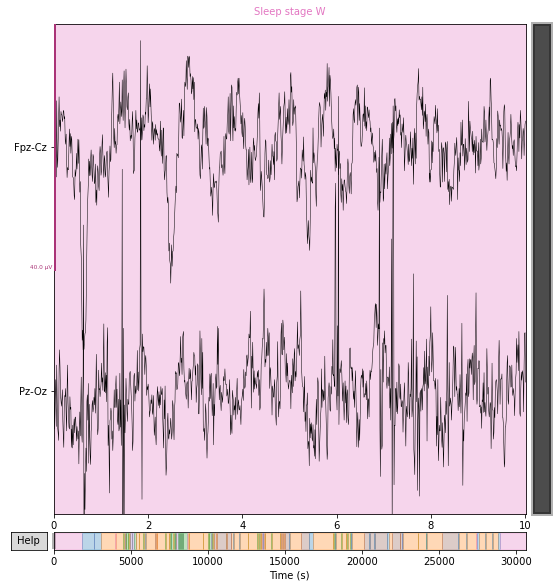

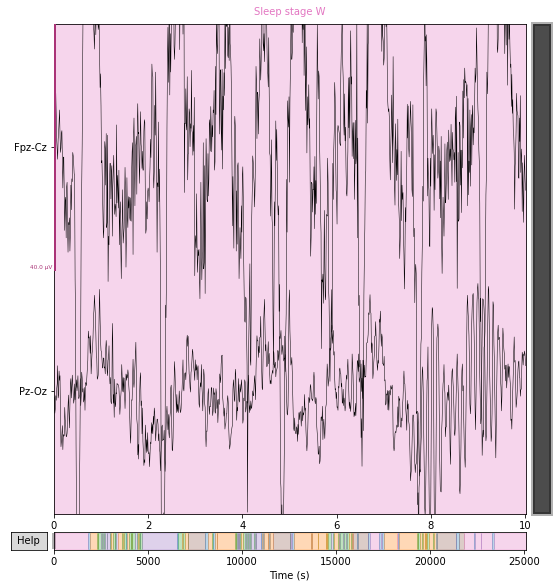

In [95]:
# Plot a recording as a sanity check
raws[4].plot();
raws[0].plot();

## Preprocessing raw data

here we preprocess the raw data using a simple filtering step, followed by the extraction of 30-s windows.
<br>
The majority of the significant information in sleep EEG data is found below 30 Hz. As a result, we add a lowpass filter with a cutoff frequency of 30 Hz to our recordings to reduce the influence of higher frequency noise.

